# Overview

The heterogeneity of Alzheimer's Disease (AD) across neuropathologies, clinical presentations, and progression trajectories presents significant challenges in establishing standardized diagnostics and developing targeted treatment for diverse patient groups. 

Identification of the neuropathology driving different clinical presentations is made difficult by the fact that the hallmark biomarker in AD diagnosis, amyloid-beta (Aβ), does not differ significantly across the AD variants, including amnestic AD and non-amnestic AD such as those with executive function, language, or visual-spatial impairments. However, with recent advancements in positron emission topography (PET) imaging, tau has been highlighted to have more agreement with the neurodegenration patterns underlying differnet clincal subtypes [1]. 

Yet, despite the increased application of data-driven methods to characterize brain disease heterogeneity in the past decade, very limited number of studies have invovled tau-PET as a modality in clustering. Additionally, the multitude of methods and parameter selections employed in previous studies complicates the validation of robust AD subtypes among studies [2]. Aside from method and modality, existing clinical trials mostly recruit late-onset AD (LOAD) patients with memory deficit, which limits the heterogeneity represented in the study cohorts [3]. 

To address these limitations, this project project aims to identify robust AD subtypes based on the topographic distribution of tau by applying robust data-driven clustering methods on baseline tau-PET of sporadic early-onset AD (EOAD) patients from the Longitudinal Early-onset Alzhiermer's Disease Study (LEADS).


In [56]:
# Import libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys 
from matplotlib.lines import Line2D
sys.path.append('../') 

# Data Description

### Study
LEADS is a prospective multisite observational clinical and biomarker study seeking to accomplish comparisons of baseline and longitudinal characteristics of EOAD v.s. LOAD and investigate the contribution of apolipoprotein E (APOE) genotype in EOAD. Similar to the Alzheimer's Disease Neuroimaging Initiative (ADNI), LEADS incorporates longitudinal clinical and cognitive assessments with imaging and biofluid markers to characterize AD holistically. However, the study recruits participants aged 40-64 and does not exclude AD patients with predominantly non-amnesic presentations. 

### Subjects
All Subjects meet the following criteria: age between 40 - 64 when consent, not pregnant or lactating, with no lifetime history of other brain disorder, no prior participation in aβ/tau targeted therapeutic trials, no moderate or severe substance abuse, no suicidal behaviors/ideations in the past 12 mo. 

This project includes 379 Aβ positive sporadic (no autosomal AD mutations) EOAD patients and 89 cognitively normal Aβ negative age-matched controls. A subject is assigned to the EOAD cohort if their amyloid PET has both a positive visual read and a global SUVR >= 1.18. If both are negative then assign to control. In the case of discordance between PET quantification and visual read, an additional reader is assigned to provide a tie-breaking visual read that decides the final assignment of the subject.

### Tau-PET
All subjects undergo MRI scan, 18F-Florbetaben Amyloid PET, and 18F-Flortaucipir Tau PET at baseline. Tau-PET images are co-registered to T1 structural MRI images and normalized with respect to the inferior cerebellar gray to derive standardized uptake value ratio (SUVR) images. The parcellations were performed using the Desikan–Killiany atlas [4], resulting in segmentation into 72 regions. The parcellations were subsequently combined into ten lobar regions of interest (ROIs) - left and right medial temporal lobe (MTL), parietal lobe, occipital lobe, frontal lobe, and temporal lobe. For each ROI, the volume-weighted mean SUVR was calculated, providing quantitative measures of regional tau distributions. 

# Input preparation  

In [2]:
dat = pd.read_csv('data.csv')
# visit = 1, parc = hemfs_roi - dropped
dat.drop(['visit','roi_full','parc','ftp_date'],axis=1,inplace=True)
dat.head(2)

,subj,dx,roi,suvr,vol
0,LDS0070120,CN,L_amygdala,1.117458,1818
1,LDS0070166,EOAD,L_amygdala,1.933520,1159


In [3]:
## Patient count
for i in dat.dx.unique():
    print(i + ': '+str(len(dat[dat.dx==i].subj.unique())))

CN: 89
EOAD: 379


**ROI Specification** 


ROI definition is a key step in data preprocessing that could impact the result of clustering. The choice to group them into left and right lobar ROI is informed by previous studies highlighting variations in AD pathology across specific lobes, potential hemispheric laterality in AD clinical variants, and the orthogonality of these lobar regions to disease progression in Braak stages IV–VI [5].


**Lobe Mapping**

Following the grouping of Desikan-Kiliany cortical parcellations into lobar regions [6]:

Medial temporal lobe:
entorhinal cortex, parahippocampal gyrus, fusiform gyrus (temporal pole)

Tempoeral lobe:
superior temporal gyrus, middle temporal gyrus, inferior temporal gyrus, transverse temporal gyrus, (bank)

Frontal lobe:
superior frontal gyrus, middle frontal gyrus, inferior frontal gyrus (pars opercularis, pars triangularis, pars orbitalis), orbitofrontal, precentral gyrus, paracentral lobule (frontal pole)

Parietal lobe:
postcentral gyrus, supramarginal gyrus, superior parietal, inferior parietal, percuneus

Occipital lobe:
lingual gyrus, pericalcarine cortex, cuneus cortex, lateral occipital cortex

Cingulate (grouped into the above):
rostral anterior (frontal), caudal anterior (frontal), posterior (parietal), isthmus (parietal)


In [4]:
# create dict to map parcellations to lobar ROI
lobe_dict = {
'L_MTL': ['L_entorhinal','L_amygdala','L_hippocampus' ],
'R_MTL': ['R_entorhinal','R_amygdala','R_hippocampus'],

'L_temporal': ['L_superiortemporal', 'L_middletemporal', 'L_inferiortemporal','L_transversetemporal',
               'L_parahippocampal','L_fusiform'],
'R_temporal': ['R_superiortemporal', 'R_middletemporal','R_inferiortemporal','R_transversetemporal',
               'R_parahippocampal','R_fusiform'],

'L_frontal':['L_superiorfrontal','L_rostralmiddlefrontal','L_caudalmiddlefrontal', #middle frontal gyrus
             'L_parsopercularis', 'L_parsorbitalis', 'L_parstriangularis', #inferior frontal gyrus 
            'L_lateralorbitofrontal','L_medialorbitofrontal', #occipitalfrontal cortex
            'L_rostralanteriorcingulate', 'L_caudalanteriorcingulate',#cingulate
            'L_precentral','L_insula',],
            
'R_frontal':['R_superiorfrontal', 'R_rostralmiddlefrontal', 'R_caudalmiddlefrontal',
             'R_parsopercularis', 'R_parsorbitalis', 'R_parstriangularis',  
             'R_lateralorbitofrontal','R_medialorbitofrontal',
             'R_rostralanteriorcingulate','R_caudalanteriorcingulate', 
              'R_precentral', 'R_insula'], #paracentral?
 
'L_occipital':['L_lateraloccipital','L_lingual','L_cuneus','L_pericalcarine'],
'R_occipital':['R_lateraloccipital','R_lingual','R_cuneus','R_pericalcarine'],

'L_parietal':['L_superiorparietal','L_inferiorparietal','L_supramarginal',
             'L_postcentral','L_precuneus',
             'L_posteriorcingulate','L_isthmuscingulate'],#cingulate
'R_parietal':['R_superiorparietal','R_inferiorparietal','R_supramarginal',
              'R_postcentral','R_precuneus', 
             'R_posteriorcingulate', 'R_isthmuscingulate'],
}
# use this to subset data for correct ordering!
lobes = ['L_MTL', 'R_MTL', 'L_temporal', 'R_temporal', 'L_frontal', 'R_frontal', 
         'L_occipital', 'R_occipital','L_parietal', 'R_parietal' ]
dat['lobe'] = dat['roi'].apply(lambda roi: next((lobe for lobe, regions in lobe_dict.items() if roi in regions), None))
dat.sort_values('subj').head(2)

,subj,dx,roi,suvr,vol,lobe
0,LDS0070120,CN,L_amygdala,1.117458,1818,L_MTL
23868,LDS0070120,CN,R_lingual,1.089886,8735,R_occipital


In [5]:
#unassigned parcellated region: 
#banks of the superior temporal sculus (temporal), frontal pole (frontal), paracentral (frontal/parietal?), temporal pole (temporal)
dat[dat.lobe.isnull()].roi.unique()

array(['L_bankssts', 'L_frontalpole', 'L_paracentral', 'L_temporalpole',
       'R_bankssts', 'R_frontalpole', 'R_paracentral', 'R_temporalpole'],
      dtype=object)

## mean SUVR

In [62]:
## Volume-weighted mean SUVR
wdata = dat.dropna().groupby(['subj', 'dx',  'lobe']).apply(lambda x: np.average(x['suvr'], weights=x['vol'])).reset_index(name='mean_suvr')
wdata.head(2)

,subj,dx,lobe,mean_suvr
0,LDS0070120,CN,L_MTL,1.212698
1,LDS0070120,CN,L_frontal,1.037903


In [63]:
# long to wide  
df = wdata.pivot_table(index=['subj', 'dx'], columns='lobe', values='mean_suvr').reset_index()
df.columns.name = None
cn_idx = df.index[df['dx'] == 'CN']
eoad_idx = df.index[df['dx'] == 'EOAD']
suvr_dat = df.loc[:,lobes].values
df.head(2)


,subj,dx,L_MTL,L_frontal,L_occipital,L_parietal,L_temporal,R_MTL,R_frontal,R_occipital,R_parietal,R_temporal
0,LDS0070120,CN,1.212698,1.037903,1.103603,1.074372,1.127232,1.210549,1.028599,1.109314,1.082730,1.142007
1,LDS0070166,EOAD,1.856240,2.398487,2.957153,3.012157,2.856721,1.695600,2.164095,2.754564,2.877221,2.635381


The input is stored in the wide format where each column represents the mean SUVR of one of the ten lobar ROIs for a subject. 

## visualize value distribution

In [7]:
def roi_cluster_violin(data, x, y,roi_name,hue_cat,title_text,labels,strip=True,colors = sns.set_palette('tab20'),**kwargs): 
    #each x gets its own violin. hue splits the violin. each roi get its own plot. 
    #inner: “box”, “quart”, “point”, “stick”,
    # Define the pairs  
    pairs = [
        ('L_MTL', 'R_MTL'),
        ('L_temporal', 'R_temporal'),
        ('L_frontal', 'R_frontal'),
        ('L_occipital', 'R_occipital'),
        ('L_parietal', 'R_parietal')
    ]
    fig, axes = plt.subplots(1,5,figsize=(26,6), sharey = True)#, dpi=480)

    for i, (lobe_l, lobe_r) in enumerate(pairs):
        #row = i // 5
        col = i % 5
        sns.violinplot(data=data[data[roi_name].isin([lobe_l, lobe_r])], x=x, y=y, hue=hue_cat, 
                    split=True,
                    fill=False,
                    ax=axes[col],palette=colors,**kwargs)
        if strip:
            sns.stripplot(data=data[data[roi_name].isin([lobe_l, lobe_r])], 
                      x=x, y=y, hue=hue_cat, 
                    dodge=True,jitter=True, alpha=0.5, size = 4, legend = False,ax=axes[col],palette=colors)#marker='o'

        axes[col].set_title(lobe_l[2:],fontsize=16)
        axes[col].set_xlabel(None)
        axes[col].set_ylabel(None)#lobe_l[2:],fontsize=16)
        axes[col].tick_params(axis='y', labelsize=16)    
        axes[col].tick_params(axis='x', labelsize=16)   

        # Set legend to None for all subplots except the last one
        if i != len(pairs):
            handles, _ = axes[ col].get_legend_handles_labels()
            axes[col].legend().set_visible(False)  

    # Create a single legend in the last subplot
    axes[0].legend(handles, labels, loc='upper left')
    plt.yticks(size=15)
    plt.suptitle(title_text,fontsize=16)
    plt.tight_layout()
    plt.show()


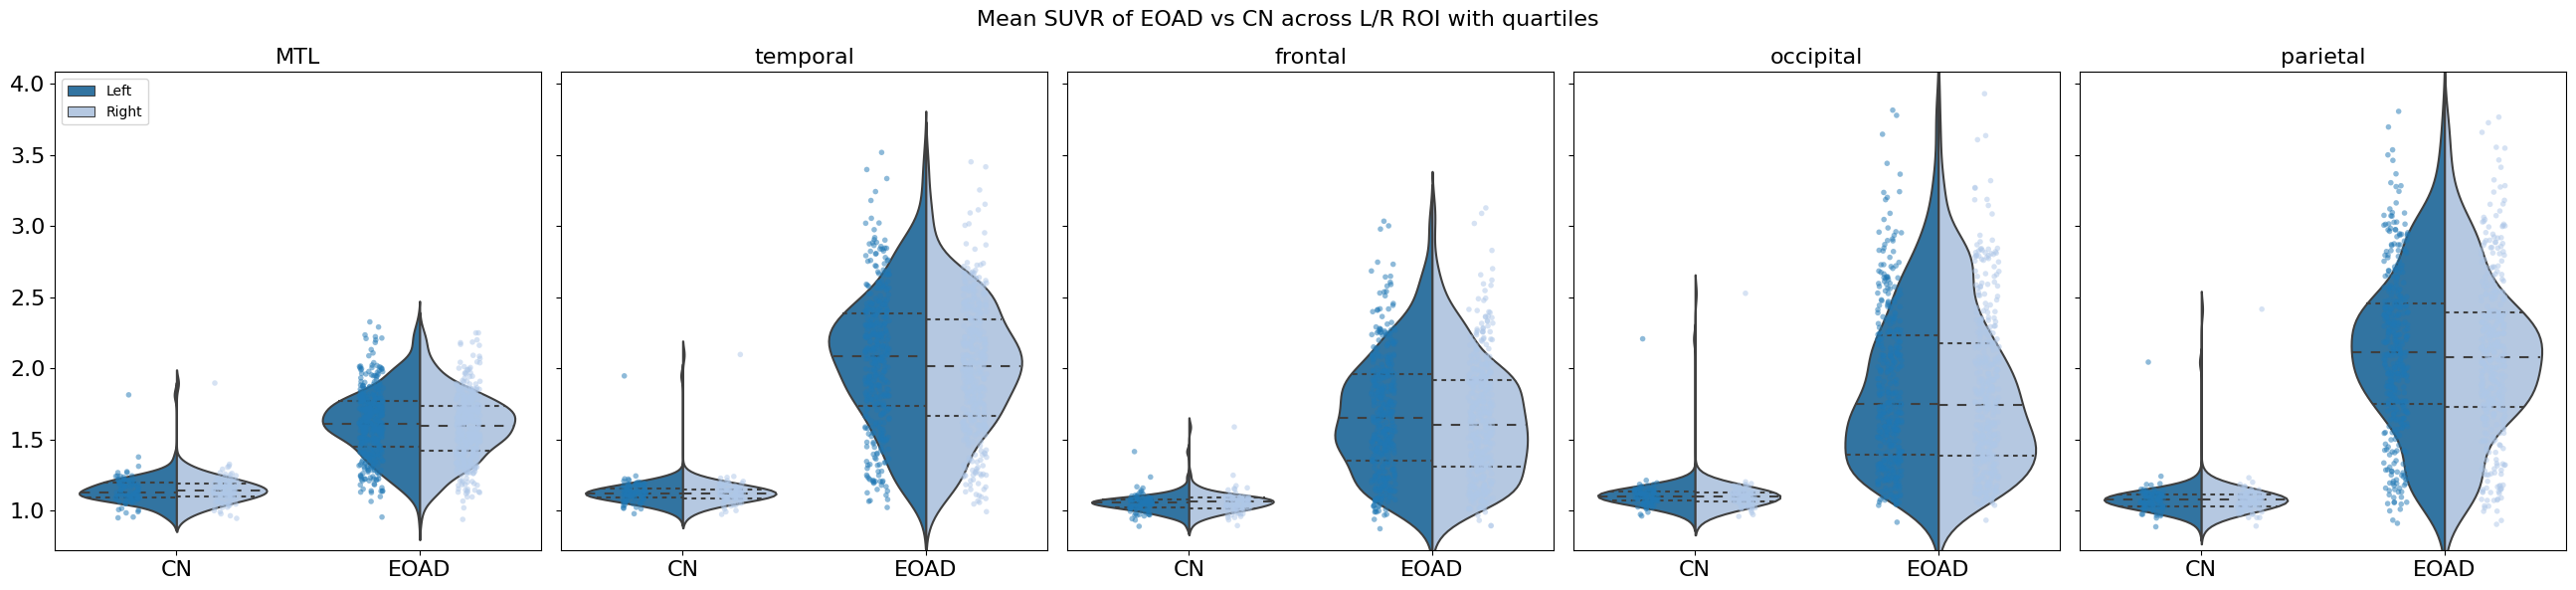

In [8]:
roi_cluster_violin(wdata,
                   x = 'dx',
                   y = 'mean_suvr',
                   roi_name = 'lobe',
                   hue_cat = 'lobe',
                   title_text = 'Mean SUVR of EOAD vs CN across L/R ROI with quartiles',
                   labels = ['Left','Right'],
                   strip = True,
                   colors = sns.set_palette('tab20'),
                   #additional
                   inner='quart')

From this figure, it's observed that the distribution of mean SUVR values is largely symmetrical between the two hemispheres within both CN and EOAD, with slightly higher values in the left hemispheres, as indicated by the quartile lines. In the CN group, extreme outliers are present in all ROIs, resulting in long tails in the violin plot. Moreover, the outlier values are higher in the right hemisphere. 

## standardization

Mean SUVR values are standardized in each region w.r.t. to a normal 'noise' component derived from Guassian Mixture Model-fit, such that the tau z-scores are informative of the disease stage and the tau dispositions are comparable across the ROIs, and in this case also to eliminate the effects of the extreme outliers observed in CN. (Although looking at the mean SUVR distributions, the values are pretty close in ranges across the ROIs.) 


In [11]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

### best # of GMM components 


In [17]:
n_components_range = range(1, 6) 
bestk_df = pd.DataFrame(columns=['ROI', 'K', 'AIC']) 
for roi_idx, roi_data in enumerate(suvr_dat.T):  
    cv_aic_scores = [] #
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) #stratified by dx
    for train_index, test_index in kf.split(roi_data,df.dx.values): 
        X_train, X_test = roi_data[train_index], roi_data[test_index]  
        for n_components in n_components_range:
            gmm = GaussianMixture(n_components=n_components, random_state=42)
            gmm.fit(X_train.reshape(-1, 1))  
            means = np.sort(gmm.means_.flatten()) #smaller first
            if n_components == 1 :
                means = [means[0],np.nan] # if it's 1 component set to NaN
            aic_score = gmm.aic(X_test.reshape(-1, 1)) 
            # Store the results for each fold
            fold_results = pd.DataFrame({'ROI': lobes[roi_idx],
                                        'K': n_components,
                                        'AIC': [aic_score],
                                        'mean1':[means[0]],
                                        'mean2':[means[1]]})
            bestk_df = pd.concat([bestk_df, fold_results], ignore_index=True) 
print(bestk_df.shape)#5 components x 10 roi x 5fold = 250 
bestk_df.head(2)


(250, 5)


,ROI,K,AIC,mean1,mean2
0,L_MTL,1,31.843984,1.524820,NaN
1,L_MTL,2,22.608503,1.183449,1.656322


In [18]:
# get best K for each ROI based on lowest mean AIC scores across folds
mean_aic = bestk_df.groupby(['ROI','K']).mean().reset_index()
idx_min = mean_aic.groupby('ROI')['AIC'].idxmin()
bestK = mean_aic.loc[idx_min, ['ROI', 'K']] 
bestK.sort_values('K')

,ROI,K
1,L_MTL,2
6,L_frontal,2
16,L_parietal,2
21,L_temporal,2
26,R_MTL,2
31,R_frontal,2
41,R_parietal,2
46,R_temporal,2
12,L_occipital,3
37,R_occipital,3


/Users/linlin/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray'` for same effect.
  warnings.warn(msg, FutureWarning)


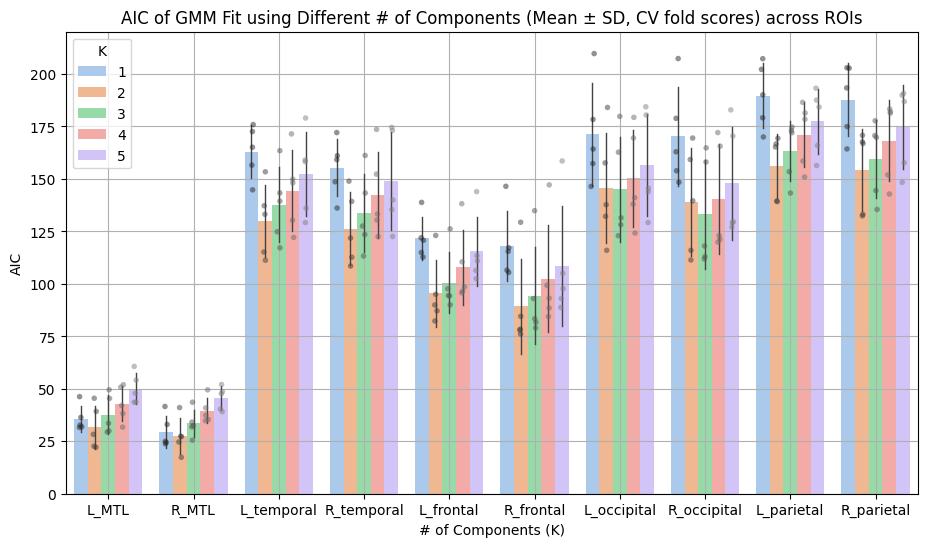

In [19]:
#AIC clustered bar
plt.figure(figsize=(11, 6))
sns.barplot(data=bestk_df, y='AIC', hue='K', x='ROI',   errorbar='sd', errwidth=1, palette=sns.color_palette('pastel')) 
sns.stripplot(data=bestk_df, y='AIC', hue='K', x='ROI', dodge=True, color='gray', alpha=0.5, size=4, legend=False)

plt.xlabel('# of Components (K)')
plt.ylabel('AIC')
plt.title('AIC of GMM Fit using Different # of Components (Mean ± SD, CV fold scores) across ROIs')
plt.legend(title='K')
plt.grid(True)
plt.show() 

For each ROI, a gaussian mixture model is fitted on the mean SUVR data to define a normal component (noise) and a abnormal component. The number of components are decided by cross-validated Akaike information criteria (AIC). In most ROIs, the distribution of mean SUVR follow a 2-GMM, one for normal and the other for abnormal tau levels. The exceptions are the occipital ROIs where 3 components give slightly better fit. 

In [68]:
def plot_mixture(gmm, roi_data, show_legend=True, ax=None):
    sns.set_palette('tab10') 
    if ax is None:
        ax = plt.gca() 
    # Whole mixture
    x = np.linspace(min(roi_data), max(roi_data), 1000)
    logprob = gmm.score_samples(x.reshape(-1, 1))
    pdf = np.exp(logprob) 
    # indiviudal component
    weights = gmm.predict_proba(x.reshape(-1, 1))
    pdf_individual = weights * pdf[:, np.newaxis]  
    # data hist
    ax.hist(roi_data, 30, density=True, histtype='stepfilled',color='gray', alpha=0.4)
    # whole pdf
    ax.plot(x, pdf, '-k', label='Mixture PDF')
    # compoennt pdf
    ax.plot(x, pdf_individual, '--')
    if show_legend:
        ax.legend()


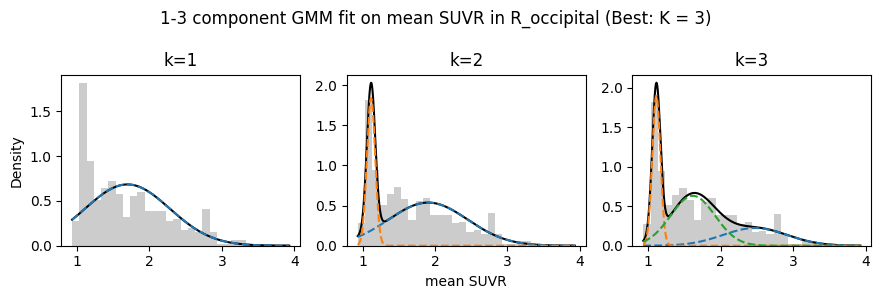

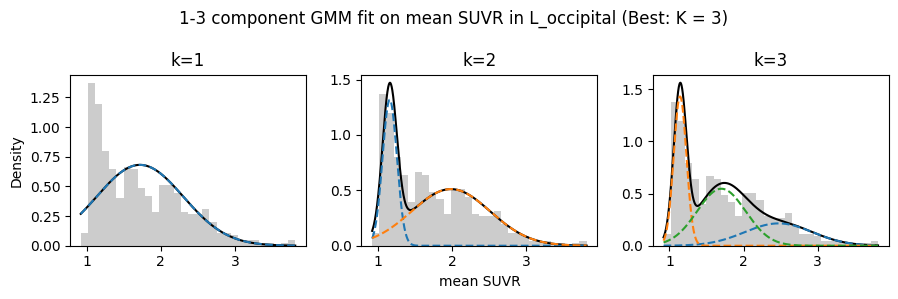

In [70]:
max_c = 3 #max num of component starting from 1
names = ['R_occipital','L_occipital'] # specify roi to plot

for roi in names:
    roi_idx = lobes.index(roi)
    roi_data = suvr_dat[:, roi_idx]   
    roibestk = bestK[bestK.ROI == roi].K.values[0]
    models = [GaussianMixture(n_components=k).fit(roi_data.reshape(-1, 1)) for k in np.arange(max_c) + 1]

    _, axes = plt.subplots(int(np.ceil(max_c/3)), 3, figsize=np.array([3,int(np.ceil(max_c/3))])*3, dpi=100,sharex=True)
    idx = 0
    for gmm, ax in zip(models, axes.ravel()):
        plot_mixture(gmm, roi_data, show_legend=False, ax=ax)
        idx = idx+1
        ax.set_title(f'k={gmm.n_components}')
        plt.suptitle(f'1-3 component GMM fit on mean SUVR in {roi} (Best: K = {roibestk})')
        # to set label
        if idx == 2:
            ax.set_xlabel('mean SUVR')
        if idx == 1:
            ax.set_ylabel('Density')
    
    plt.tight_layout()

### visualize GMM-fit in each ROI

In [79]:
def annotated_roi_dist(data, roi, stat = 'density',dattype = 'mean SUVR', gmmfit=False, separate=True, annotate=True, cn_include = True,#whether it's gmm fitted, whether separately colored CN and EOAD, whether included CN
                  ax=None, colors=sns.color_palette('tab10'), 
                  rois=lobes, eoad_idx=eoad_idx, cn_idx=cn_idx, dx=df.dx,**kwargs):
    if ax is None:
        _, ax = plt.subplots()
    
    offset = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.01
    roi_data = data[:, rois.index(roi)] 
    if roi == 'L_occipital' or roi == 'R_occipital':
        k = 3
    else:
        k = 2
    roi_df = pd.DataFrame({'roi':roi_data,'dx':dx}) 
    #gmm component or cn/eoad stats?
    if gmmfit:
        colors = sns.color_palette("Accent", 8)
        description = 'for 1st/2nd components'
        # gmm fit
        gmm = GaussianMixture(n_components=k, random_state=42)
        gmm.fit(roi_data.reshape(-1, 1))
        # mean,sd, sorted by first component = smaller mean 
        sorted_idx = np.argsort(gmm.means_.flatten())
        means = np.sort(gmm.means_.flatten())
        stds = np.sqrt(gmm.covariances_.flatten())[sorted_idx]   
        # plot overall pdf
        x = np.linspace(roi_data.min(), roi_data.max(), 1000) 
        pdf = np.exp(gmm.score_samples(x.reshape(-1, 1))) 
        plt.plot(x, pdf, color='black', linestyle='-')  
        # plot component pdf
        weights = gmm.predict_proba(x.reshape(-1, 1))
        pdf_individual = weights * pdf[:, np.newaxis] 
        for i in range(pdf_individual.shape[1]):
            plt.plot(x, pdf_individual[:,i], '--',color=colors[i])
        # plot intersection line
        filter = (x < means[1]) & (x > means[0])
        difference = np.abs(pdf_individual[:, 0][filter]  - pdf_individual[:, 1][filter])#between the means of the 2 components
        intersection = x[filter][np.argmin(difference)]  
        ax.axvline(intersection, color='red', linestyle='--',label='intersection')
        ax.text(intersection+offset, ax.get_ylim()[1]*0.8, f'{intersection:.2f}', color='red', ha='left',fontsize=14)    
    else:
        if cn_include:
            description = 'for CN/EOAD'
            means = [np.mean(roi_data[cn_idx]), np.mean(roi_data[eoad_idx])]
            stds = [np.std(roi_data[cn_idx]), np.std(roi_data[eoad_idx])]
        else:
            description = 'for EOAD only'

    #separately color cn/eoad?
    if separate:
        sns.histplot(roi_df, x='roi', hue='dx', alpha=0.3, stat=stat, multiple='stack',color=colors, ax=ax,**kwargs)
    else:
        sns.histplot(roi_df, x='roi', color='gray', alpha=0.5, stat=stat, multiple='stack', ax=ax,**kwargs)
        
    for i in range(2):
        if annotate:
            ax.axvline(means[i], color=colors[i], linestyle='--')
            ax.axvspan(means[i] - stds[i], means[i] + stds[i], color=colors[i], alpha=0.3)
            if not (gmmfit and i == 0):
                ax.text(means[i] + offset, ax.get_ylim()[1] * 0.96, f'{means[i]:.2f} ± {stds[i]:.2f}', color=colors[i], ha='left',fontsize=14)    
        ax.set_title(f'{roi} (μ±σ {description})')
        ax.set_xlabel(f'{dattype}')
        ax.set_ylabel('Density') 
    return ax



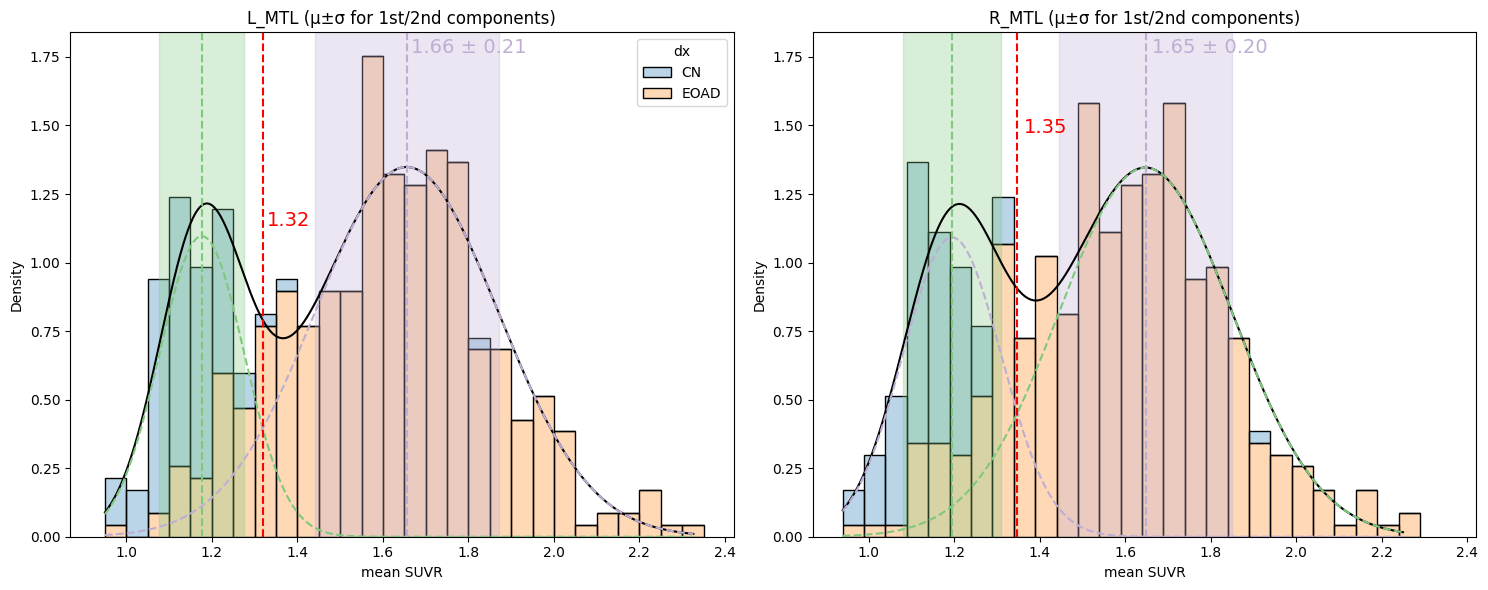

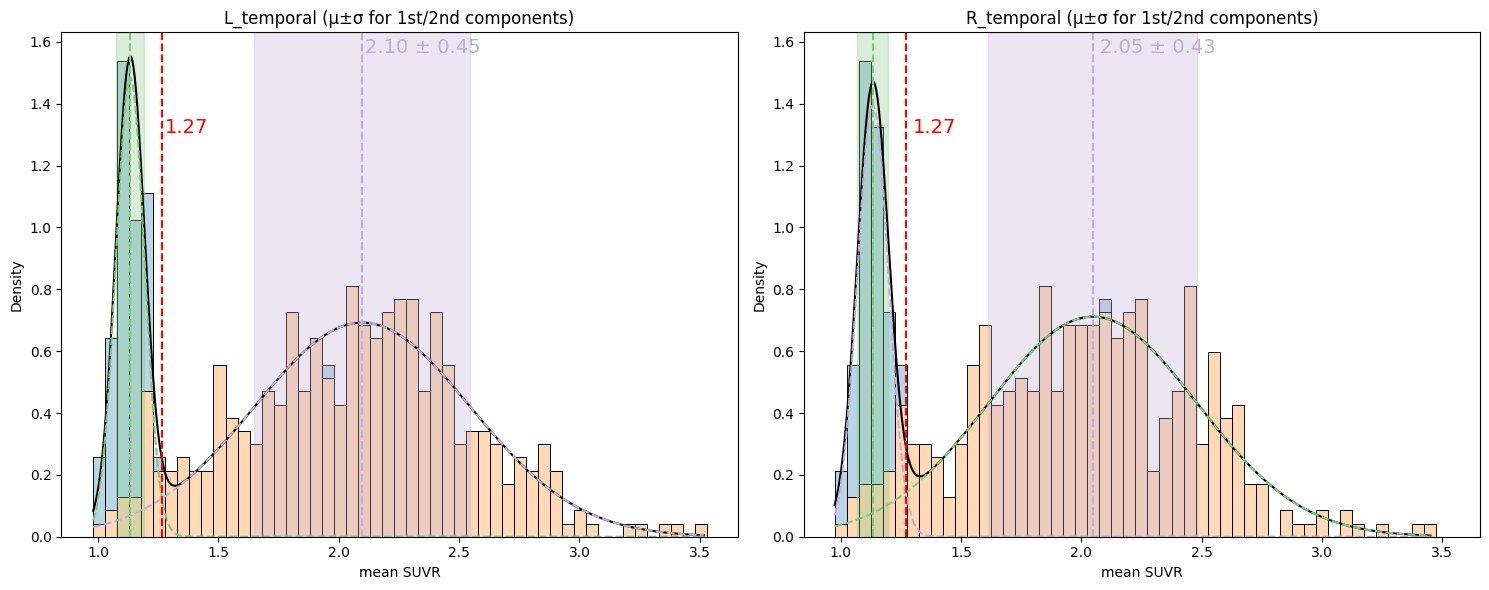

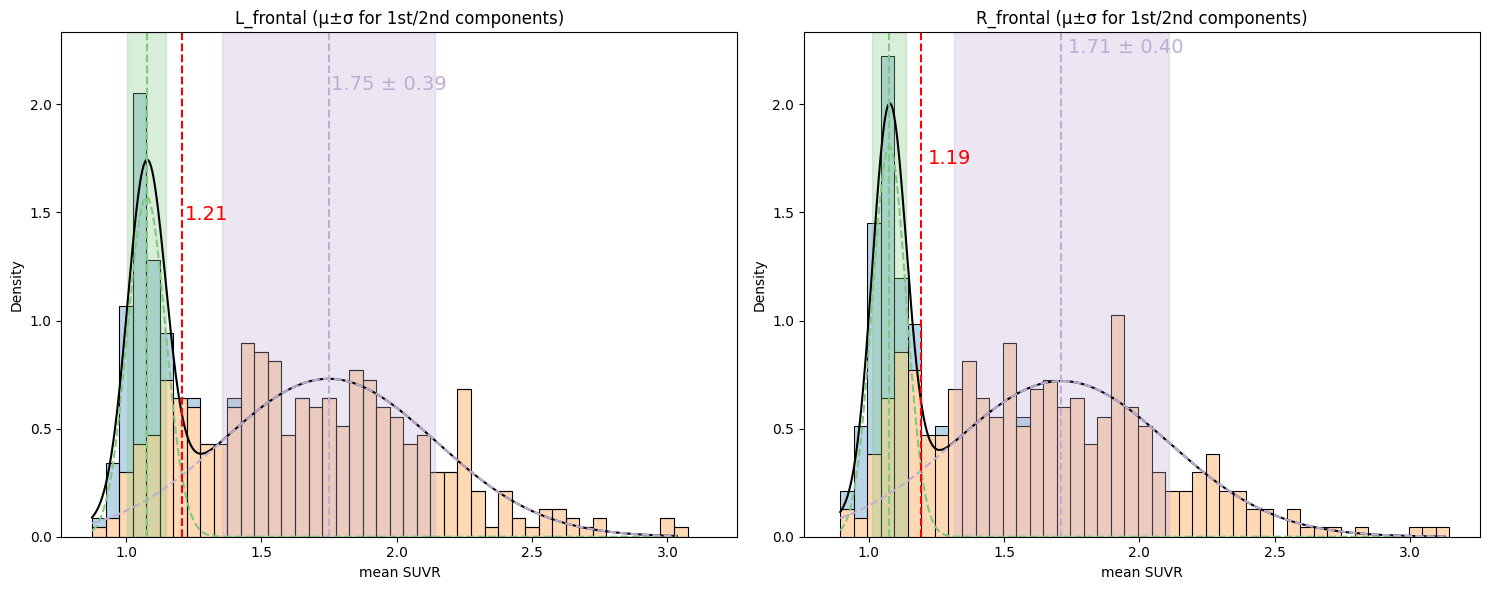

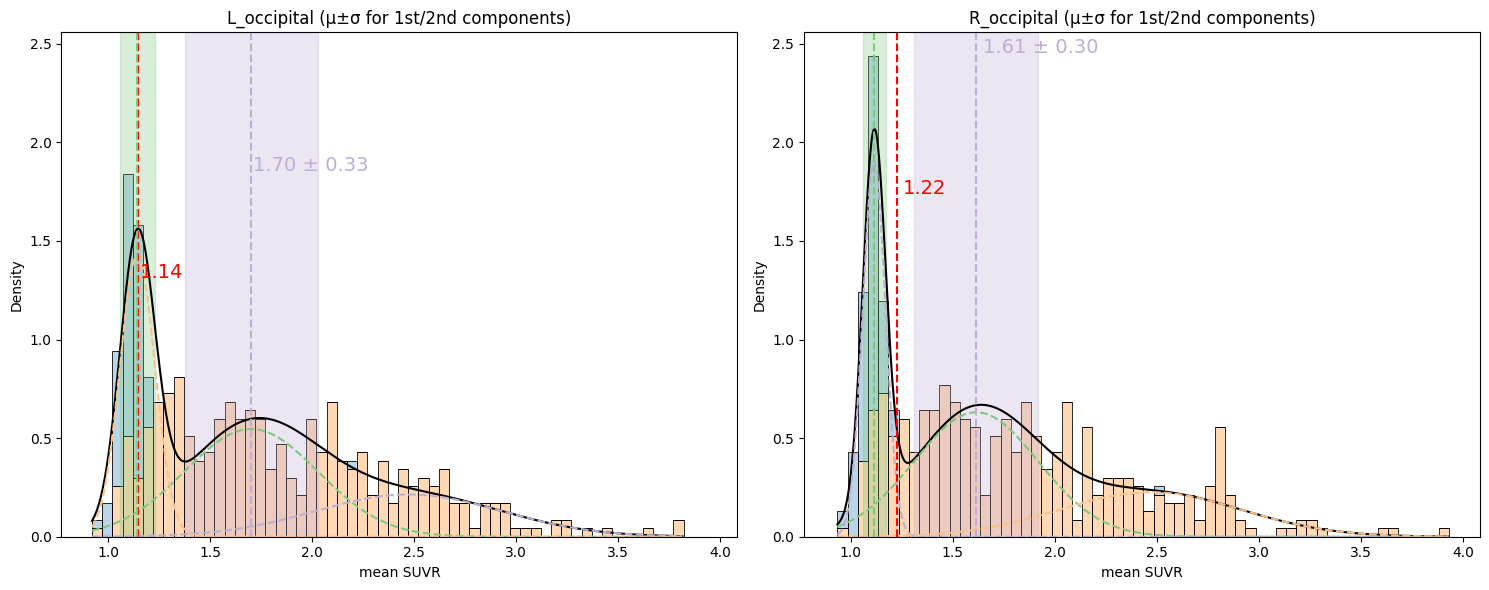

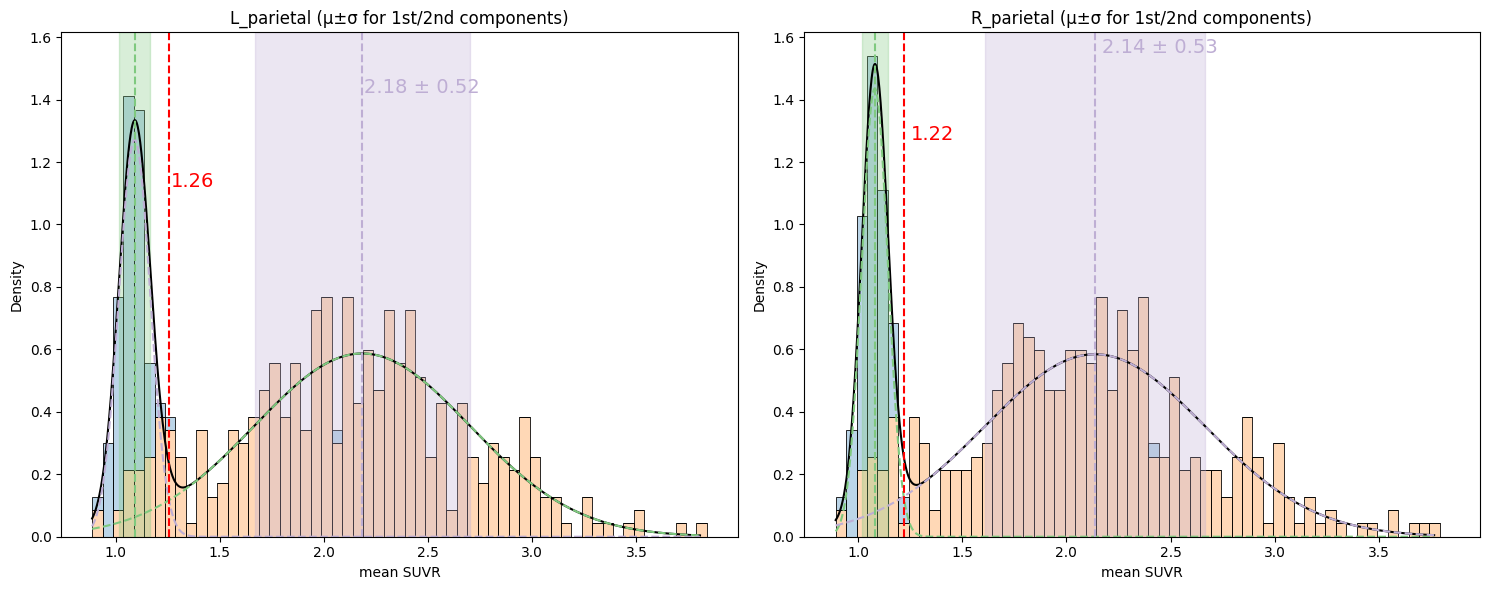

In [80]:

# if share axes for all, for stat = density, sharex for all set to 0, 50, sharey for all set to 0, 0.17
for i in list(range(0,10,2)):
    plt.figure(figsize=(15, 6))
    # Subplot for left
    ax1 = plt.subplot(1, 2, 1)
    annotated_roi_dist(data = suvr_dat, roi=lobes[i], dattype='mean SUVR', gmmfit=True, kde=False, ax = ax1,binwidth=0.05)#,stat='count'
    if i != 0:
        ax1.legend().set_visible(None)

    # Subplot for right
    ax2 = plt.subplot(1, 2, 2,sharex=ax1,sharey=ax1) #add this for same y axis. or sharex
    annotated_roi_dist(data = suvr_dat, roi = lobes[i+1], dattype = 'mean SUVR',gmmfit=True,kde=False, ax=ax2,binwidth=0.05)#stat='count',
    ax2.legend().set_visible(None)

    plt.tight_layout()
    plt.show()


The above figure shows the mean and standard deviation of the first and second component of the mean SUVR values as well as the intersection of the density functions of the two components which could be seen as a ROI-specific abnormality threshold. 

### standardize w.r.t. 1st component

In [71]:
gmm1mean = []
gmm1std = [] 
gmm_data = suvr_dat.copy()
for roi in lobes:
    roi_idx = lobes.index(roi) 
    k = bestK.loc[bestK.ROI== roi,'K'].values[0]
    gmm_model = GaussianMixture(n_components=k, random_state=42)
    # Fit GMM to the column data/a specific roi
    gmm_model.fit(gmm_data[:, roi_idx].reshape(-1, 1)) 
    # Get the means of the two components
    means = gmm_model.means_.flatten()  
    # sort it by smaller mean = first component
    c1_idx = np.argmin(means)
    std = np.sqrt(gmm_model.covariances_[c1_idx])[0][0]
    mean = means[c1_idx]
    gmm1mean.append(mean)
    gmm1std.append(std)
    #standardize
    gmm_data[:, roi_idx] = (gmm_data[:, roi_idx] - mean)/std


In [72]:
gmm_ctrl = gmm_data[cn_idx]
gmm_eoad = gmm_data[eoad_idx]

# Clustering

ref [7] https://scikit-learn.org/stable/auto_examples/cluster/index.html#clustering

## K-Means/K-Medians

K-Means/K-Medians is a distance-based general-purpose clustering algorithm that assumes all clusters have equal variance and are convex and isotropic. 

The aim of the algorithm is to minimize the inertia, or within-in-cluster sum-of-squares like the sum of Euclidean distances between points in a cluster to the mean of the cluster, such that the points within the same cluster are as homogenized/coherent as possible. When the dimension of the data is high (in this case we have 10), the distance might be inflated. While Principle Component Analysis might solve this problem it also leads to less interpretable clusters because the axes would be principle components instead of the original variables.

K-Means would be fast on the amount of data in this project but the algorithm is sensitive to initializations and the convergence might be to a local minimum. 

The number of clusters needs to be pre-determined, and is usually decided through cross-validation, which has a lot of nuisance to it like what metrics are used to optimize. 

In sklearn's implementation, there is: 1. init, which deterimines how is the cluster centers initalized. 2. max_iter, max. number of iters for each run. 3. tol, if the improvement in metric is below this value it's deemed as convergence. 4. n_init, number of times alg is run with different starting centers.

### cluster# determination

In [83]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.wa

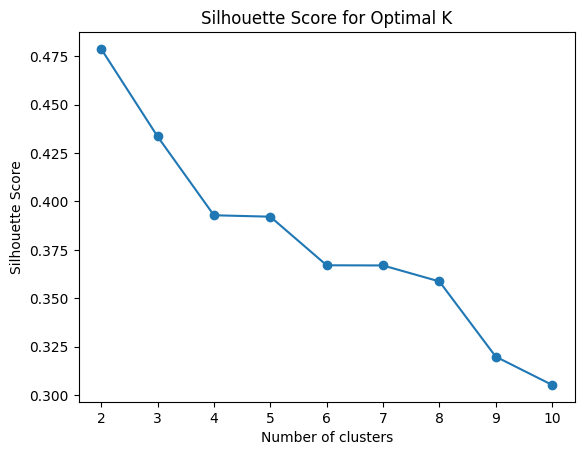

In [89]:
k_val = range(2,11)
silhouettes = []

for k in k_val:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(gmm_data)
    silhouette_avg = silhouette_score(gmm_data, cluster_labels)
    silhouettes.append(silhouette_avg)

# Plot the silhouette scores
plt.plot(k_val, silhouettes, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.show()


In [ ]:


# Instantiate the KMeans model with the desired number of clusters
kmeans_model = KMeans(n_clusters=desired_number_of_clusters)

# Fit the model to your data
kmeans_model.fit(gmm_data)

# Get the cluster labels assigned to each sample
cluster_labels = kmeans_model.labels_


## Hierarchical Clustering

## t-SNE

## U-Map

## MINISOM

# Citations
[1] (La Joie et al Neurology 2021​)

[2]  (Chen et al, Brain Research 2024)

[3]  LEADS https://alz-journals.onlinelibrary.wiley.com/doi/pdf/10.1002/alz.12350 

[4] Desikan-Killiany Atlas
 https://surfer.nmr.mgh.harvard.edu/fswiki/CorticalParcellation?highlight=%28lobar%29 

[5] Vogel

[6] https://surfer.nmr.mgh.harvard.edu/fswiki/CorticalParcellation

[7] 